# Chap03 - MCMC 블랙박스 열기

## 3.1 베이지안 지형

베이지안 추론을 위해서는 **MCMC(Markov Chain Monte Carlo)**를 다루어야만 한다. MCMC과정을 알면 알고리즘의 수렴 여부를 알 수 있다. 또한, 우리가 1, 2장에서 살펴보았던 모델링 후 수천 개의 사후확률표본을 돌려받는 이유를 이해할 수 있다.

미지수가 $N$개인 베이지안 추론 문제를 설정할 때 암묵적으로 기존에 있는 사전확률분포를 위한 $N$차원 공간을 만든다. 공간과 관련된 것이 추가 차원인데, **표면**(surface) 또는 **곡선**(curve)라고 하며, 특정한 위치의 **사전확률을**을 반영하는 공간의 상단(?)을 말한다. 공간 위 표면은 사전확률분포로 정의된다. 

예를 들어 미지수 $p_1$과 $p_2$가 있고 둘의 사전확률분포가 $\text{Uniform}(0,5)$라면 만들어진 공간은 한 변의 길이가 $5$인 정사각형이고 표면은 그 정사각형이고 표면은 그 정사각형 위에 있는 평면이다. 여기서 균등 사전확률분포를 선택했기 때문에 모든 점의 확률이 같음을 나타낸다.

In [3]:
%matplotlib inline 
import numpy as np
import matplotlib
import scipy.stats as stats

from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rc('font', family='NanumGothic')  # linux

figsize(12, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

Text(0.5,0.92,'균등 사전확률분포로 구성한 다른 방향의 모습')

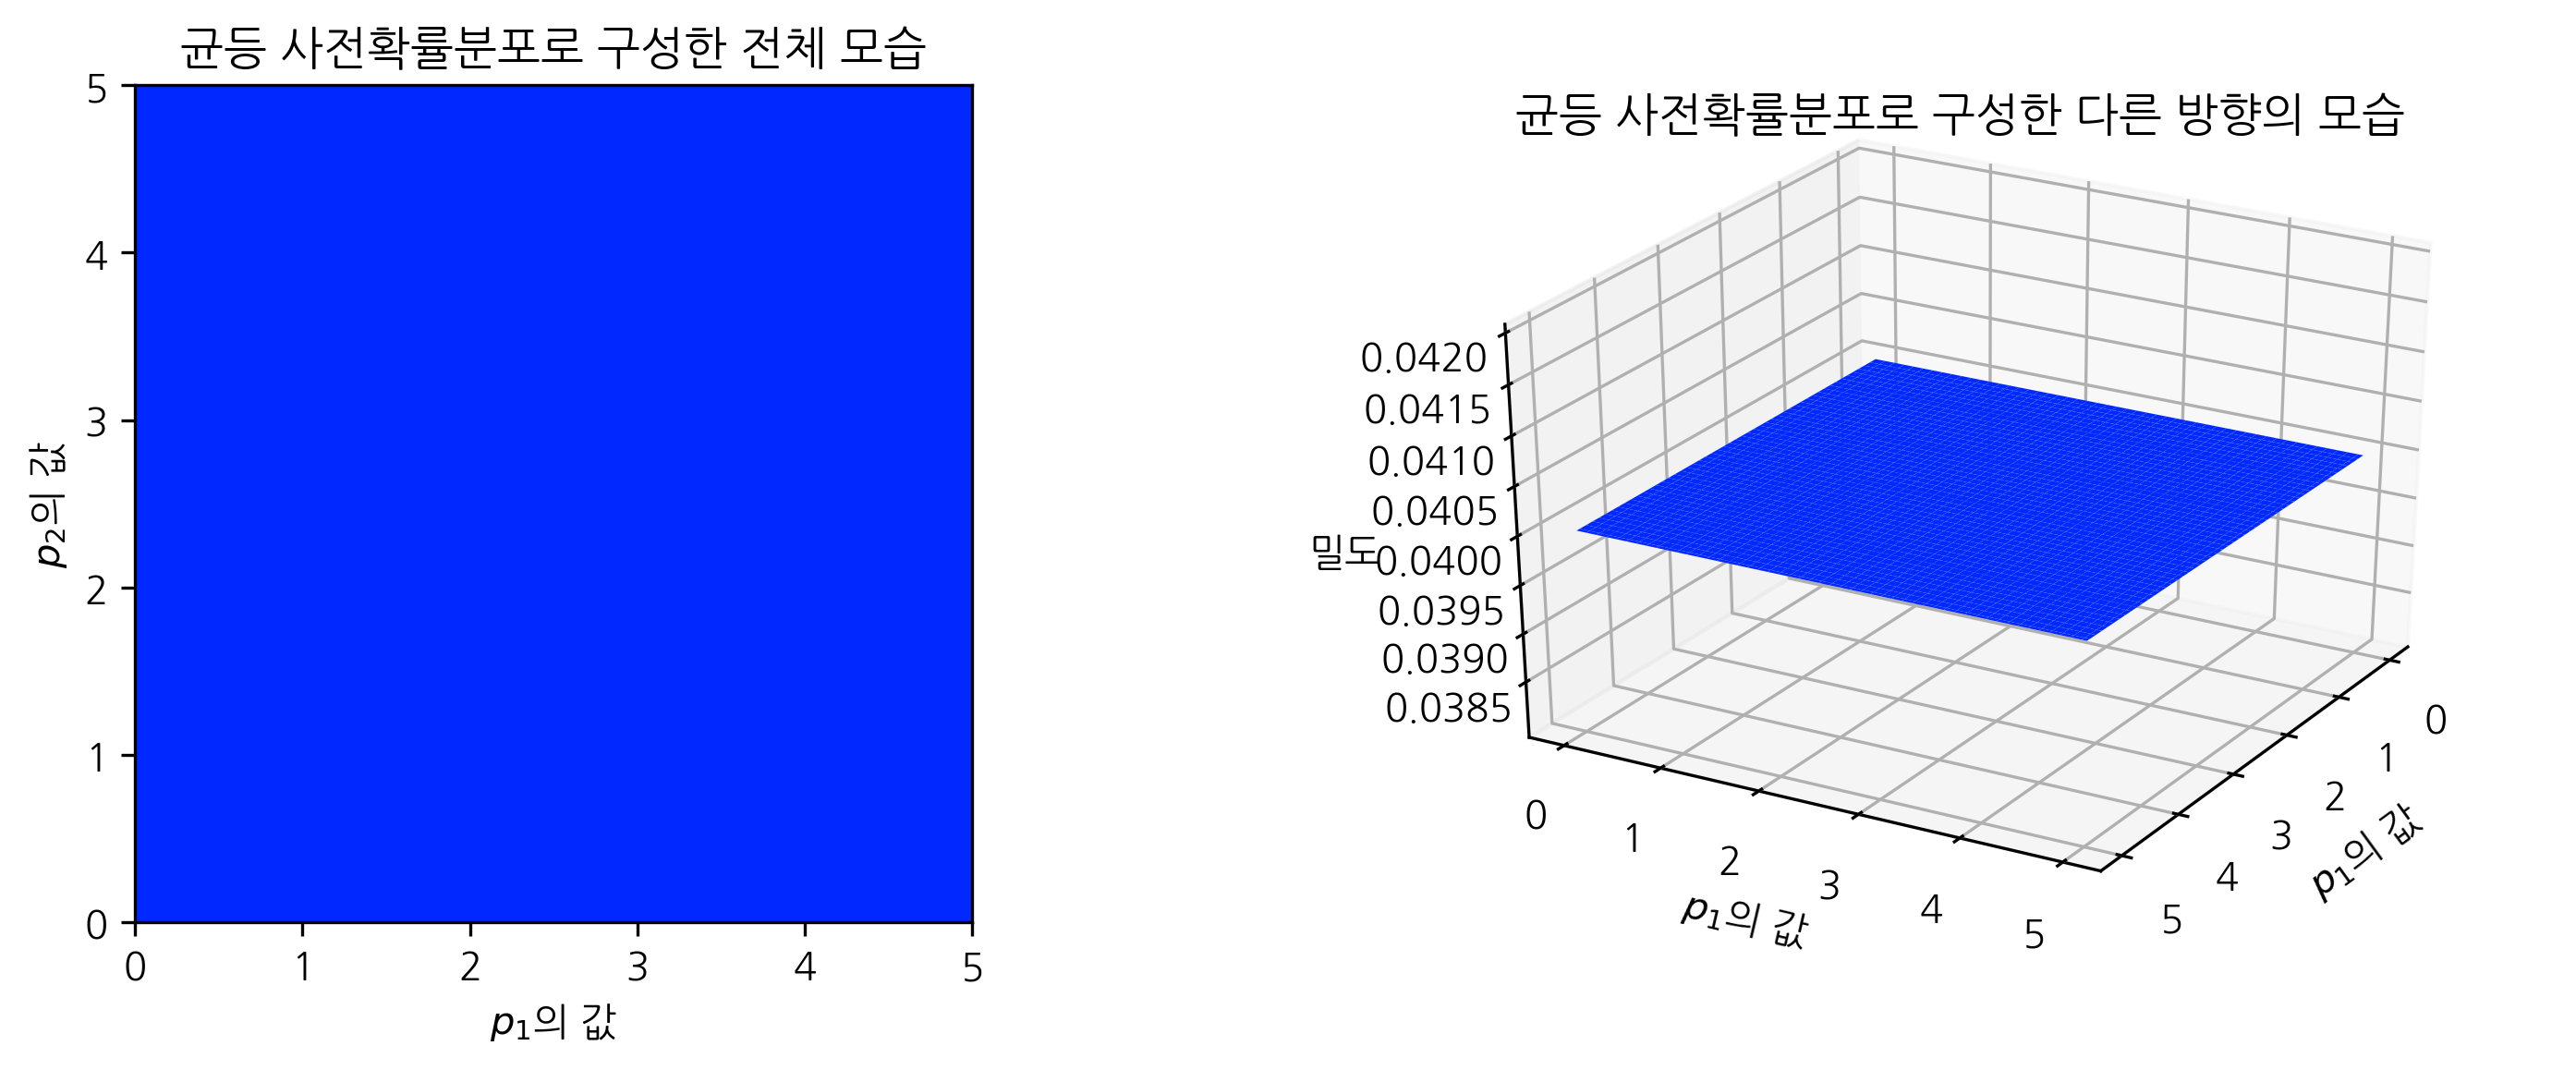

In [4]:
jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_y[:, None], uni_x[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel('$p_1$의 값')
plt.ylabel('$p_2$의 값')
plt.title('균등 사전확률분포로 구성한 전체 모습')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
ax.set_xlabel('$p_1$의 값')
ax.set_ylabel('$p_1$의 값')
ax.set_zlabel('밀도')
plt.title('균등 사전확률분포로 구성한 다른 방향의 모습')

만약, 두 사전확률분포가 $\text{Exp}(3)$과 $\text{Exp}(10)$이라면 공간은 2차원 평면에서 모두 양수다. 아래의 그림은 색상이 어두운 빨간색일수록 그 위치에 더 많은 사전확률이 할당된 것이다. 어두운 파란색일수록 그 위치에 할당된 사전확률은 매우 작다.

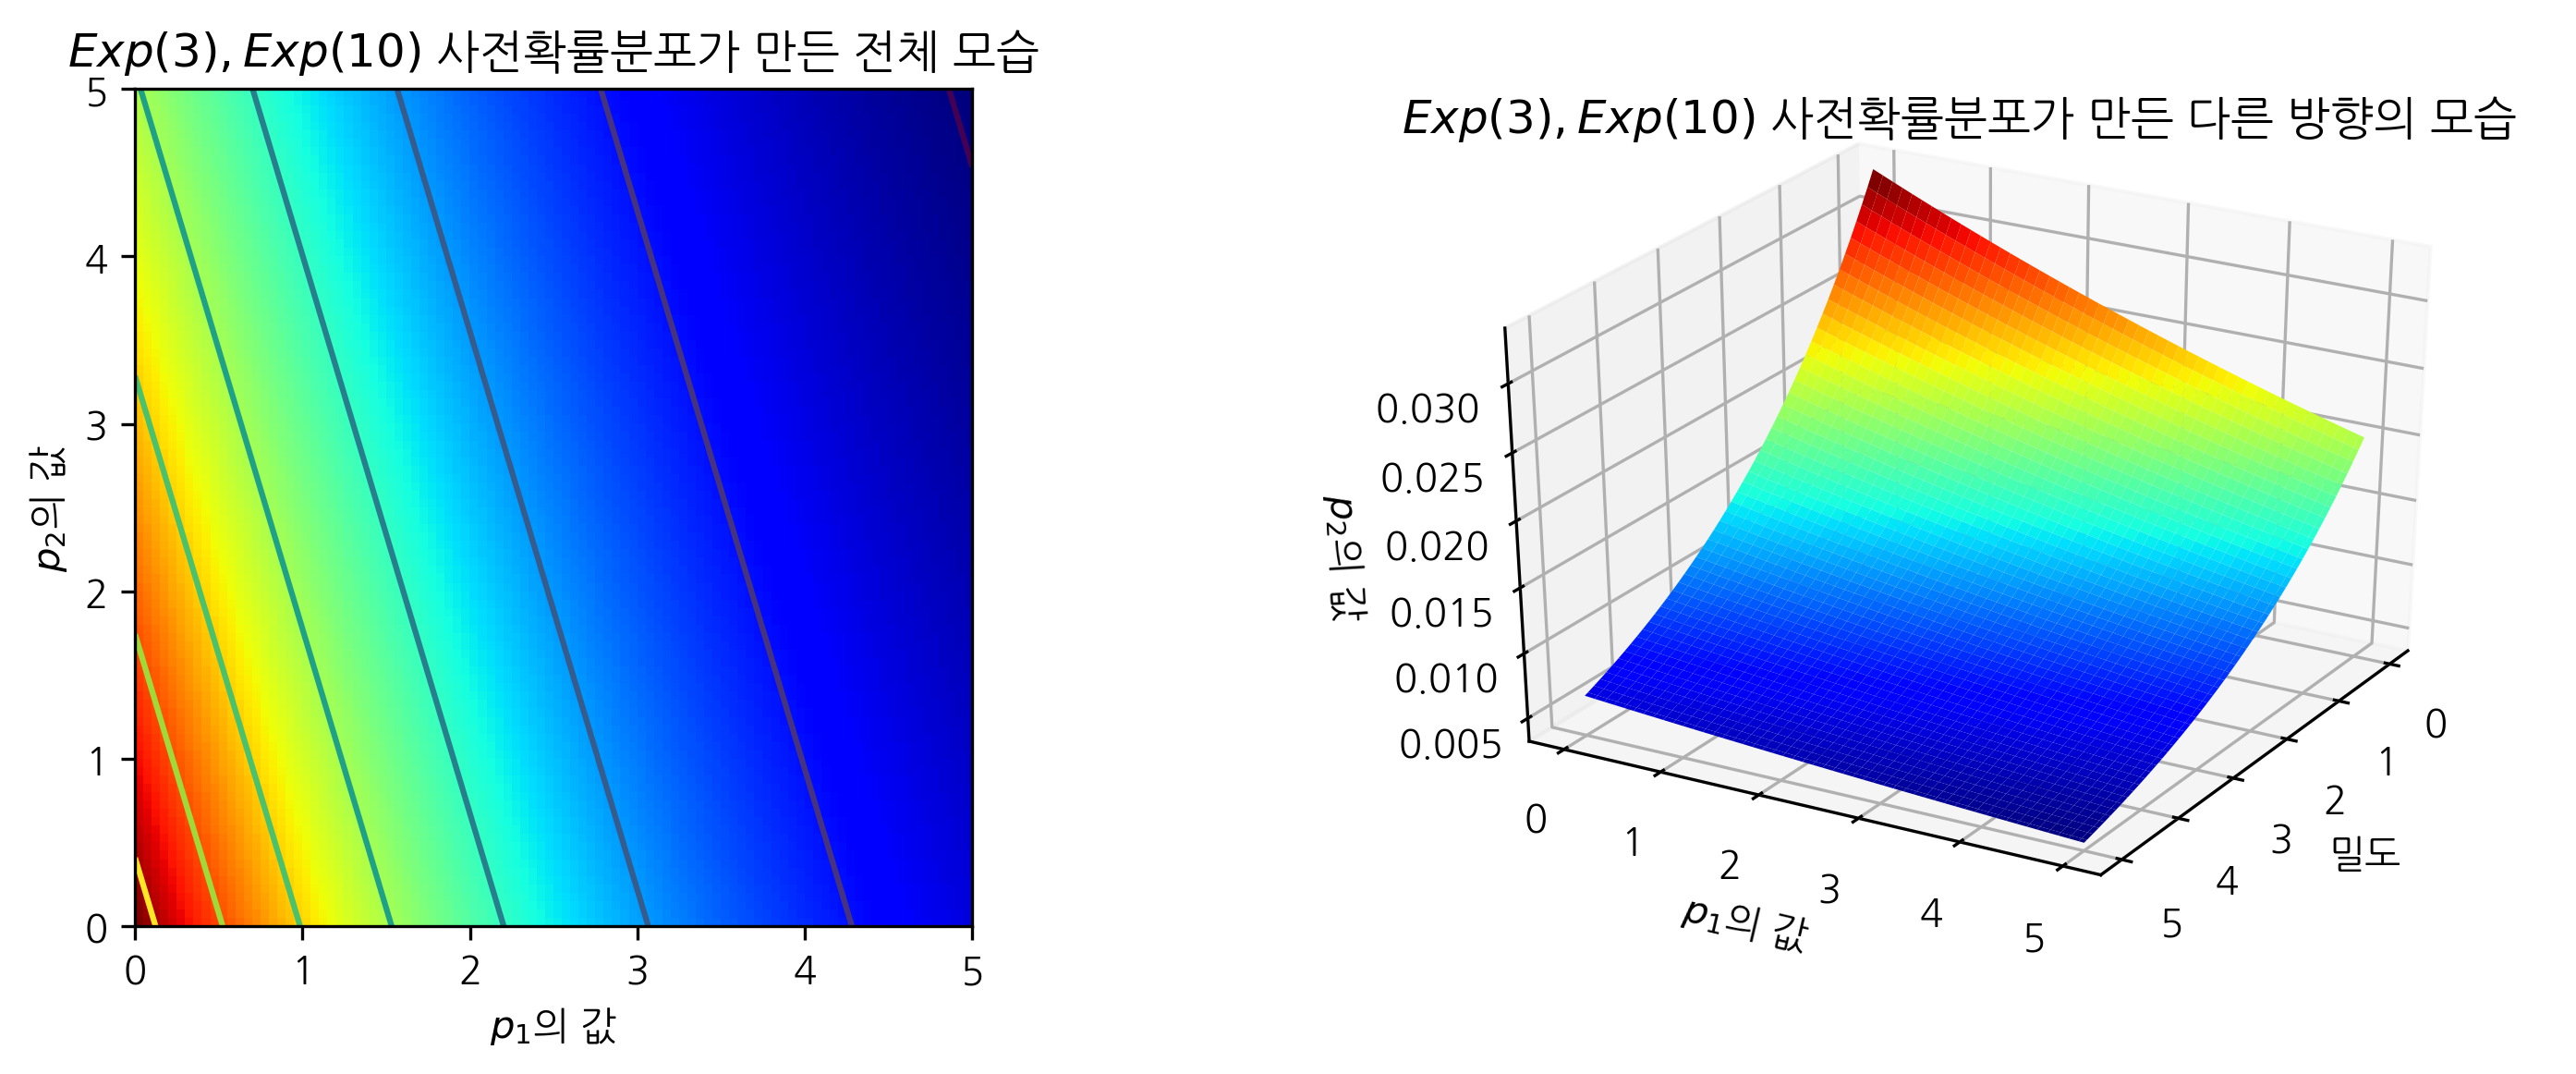

In [5]:
figsize(12, 4)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_y[:, None], exp_x[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.xlabel("$p_1$의 값")
plt.ylabel("$p_2$의 값")
plt.title("$Exp(3), Exp(10)$ 사전확률분포가 만든 전체 모습")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
ax.set_xlabel( "밀도" )
ax.set_ylabel( "$p_1$의 값" )
ax.set_zlabel( "$p_2$의 값" )
plt.title("$Exp(3), Exp(10)$ 사전확률분포가 만든 다른 방향의 모습");

위에서 본 그래프들은 확률공간의 사전확률분포에 대한 표면(surface)을 나타낸다. 

> **여기에 (관측) 데이터 $X$를 포함시키면 어떤일이 일어날까?**

데이터 $X$는 공간을 변화시키지는 않지만, 사전확률 **표면을 변화**(당기거나, 늘림)시켜 모수가 존재하는 위치를 반영한다.

- 데이터가 많을수록 표면의 변화가 크다.
- 변화된 표면은 새로운 **사후확률분포**를 보여준다.



미지의 모수 $\lambda$를 가진 두 푸아송분포를 추론한다고 가정하고, 균등 사전확률분포와 지수 사전확률분포를 사용하여 두 미지수 $\lambda$를 비교해보자. 

In [12]:
# 관측 데이터를 만든다.
# 관측 데이터의 크기 (N= 1 ~ 100)
N = 1

# 실제 모수 (가정)
lambda_1_true = 1
lambda_2_true = 3

# 위의 두 모수에 종속적인 데이터를 생성
data = np.concatenate([
        stats.poisson.rvs(lambda_1_true, size=(N, 1)),
        stats.poisson.rvs(lambda_2_true, size=(N, 1))], axis=1)
print('observed (2-dimensional, sample size = %d:)' % N, data)

x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                         for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 0], _y)
                         for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

observed (2-dimensional, sample size = 1:) [[1 3]]


(0, 5)

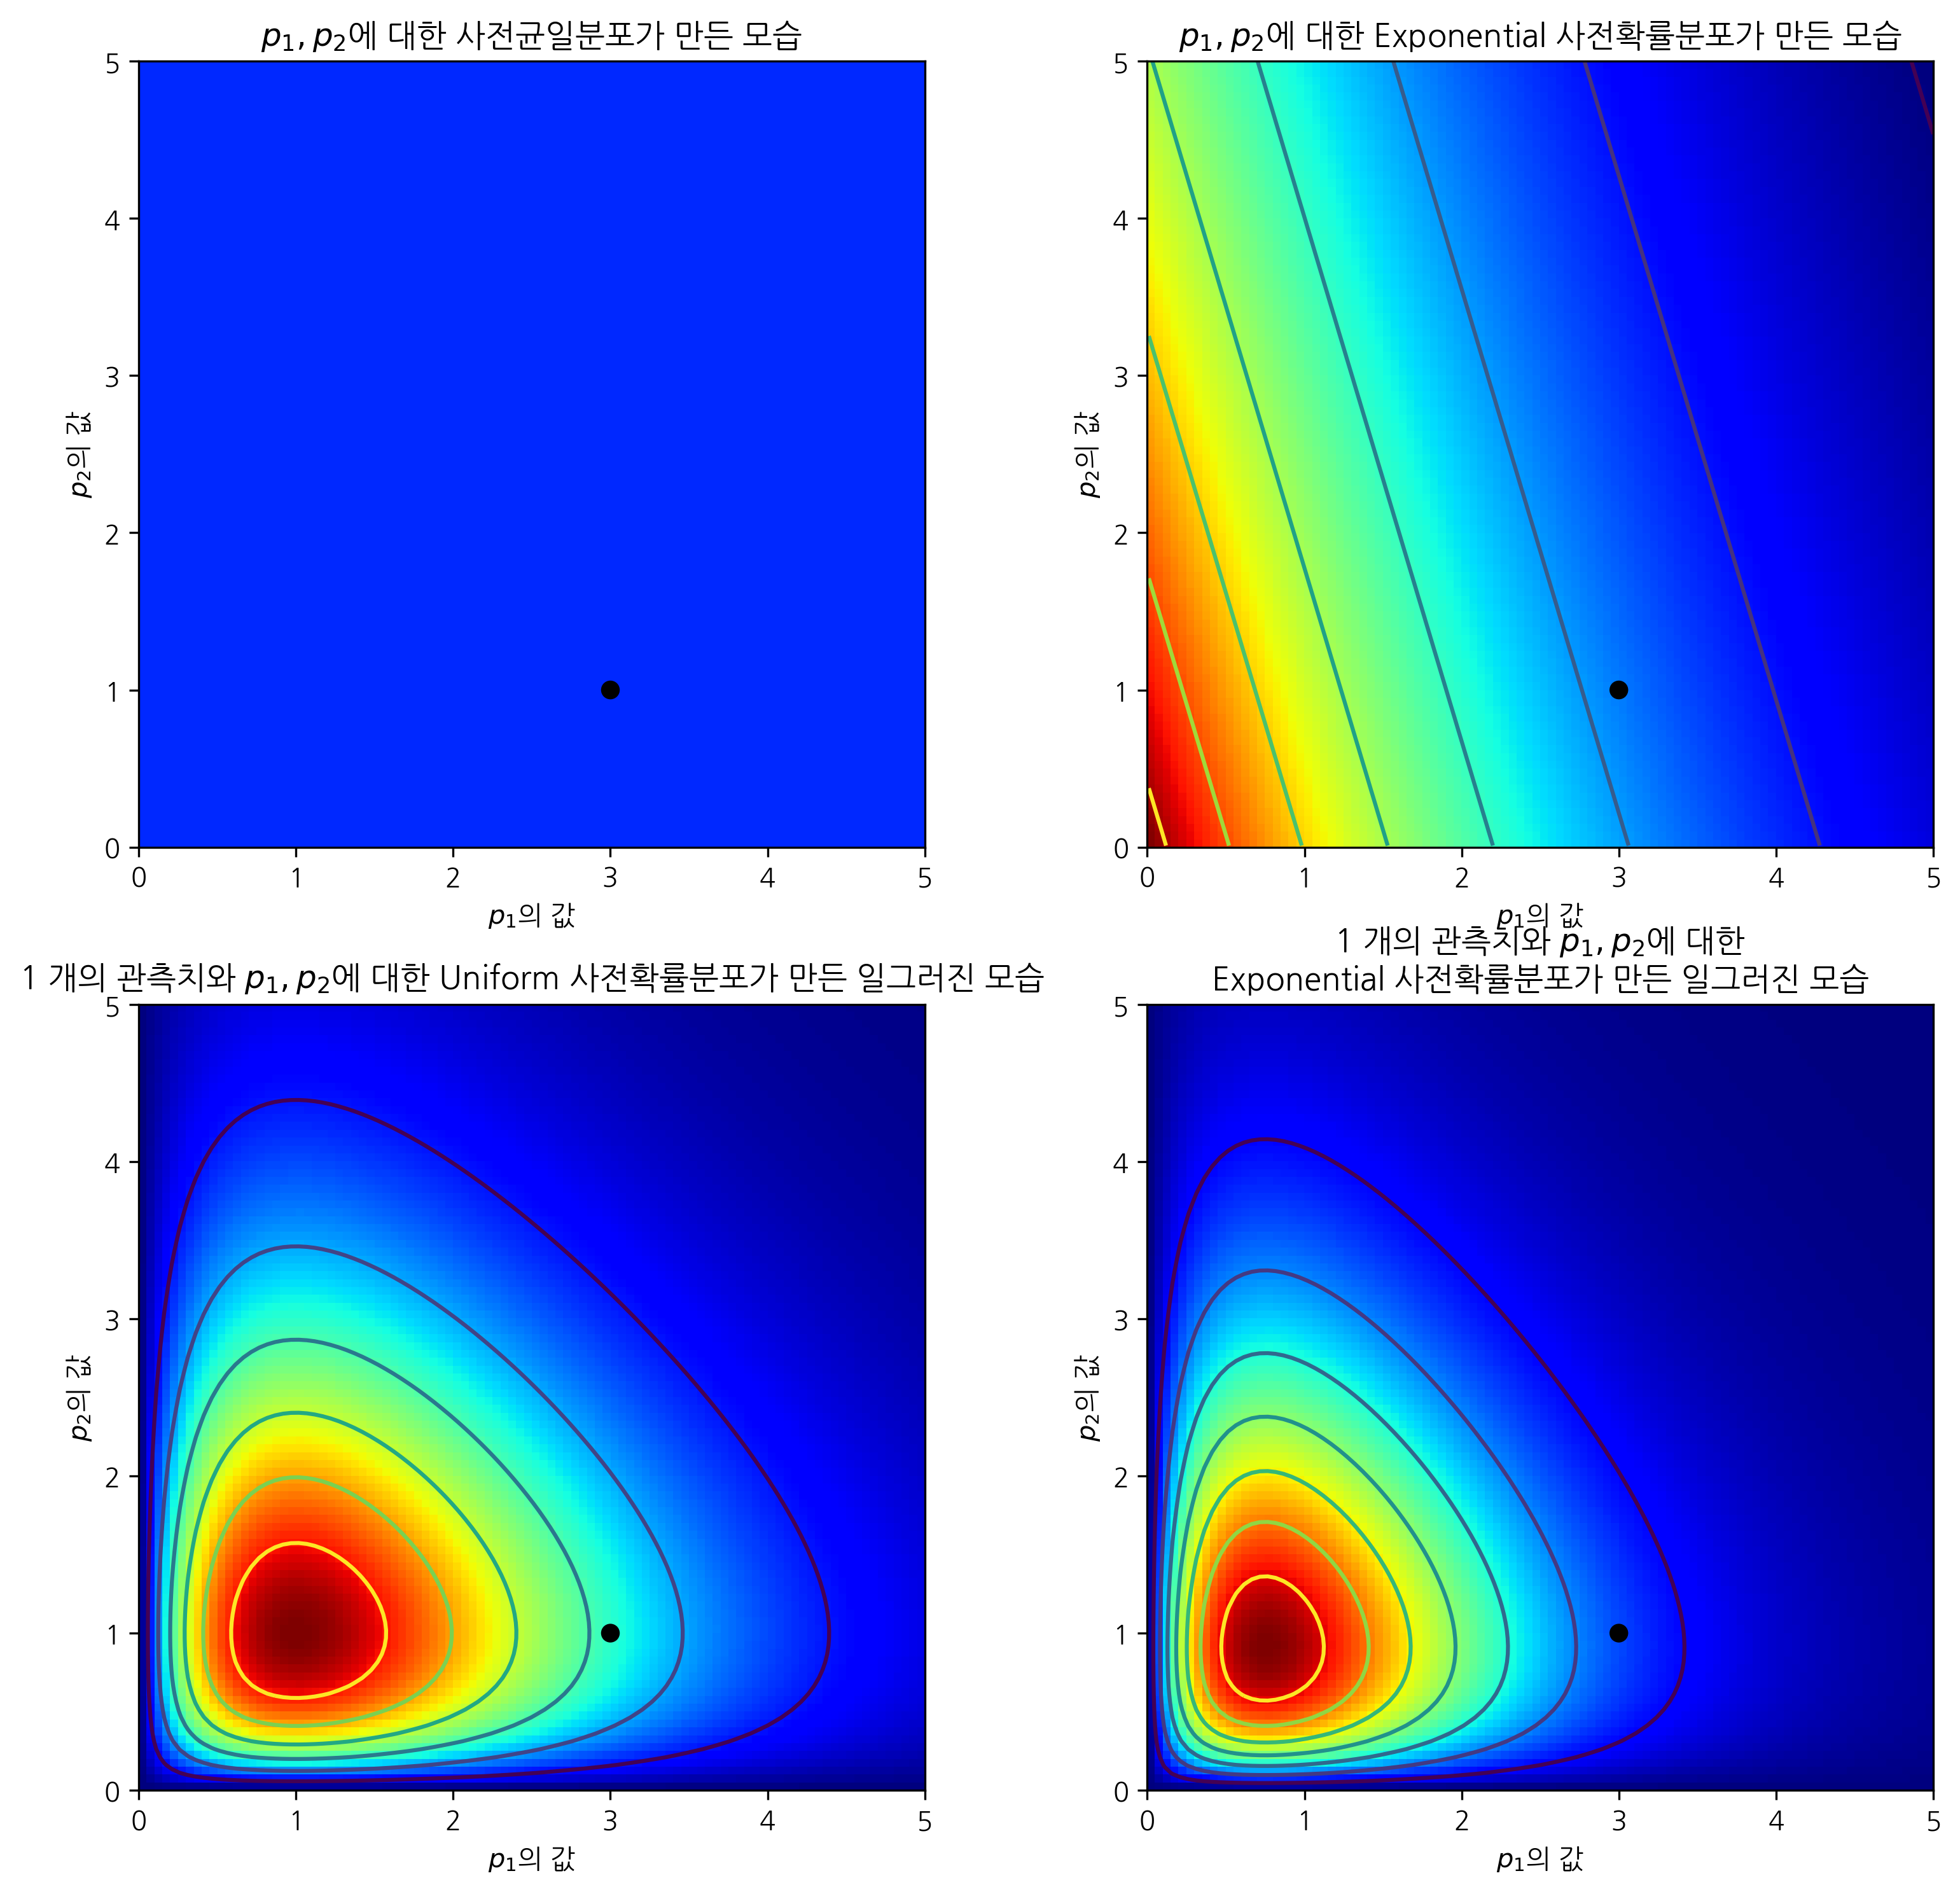

In [13]:
figsize(12.5, 12)

# matplotlib에 부하가 걸리는 작업
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_y[:, None], uni_x[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("$p_1$의 값")
plt.ylabel("$p_2$의 값")
plt.title("$p_1, p_2$에 대한 사전균일분포가 만든 모습")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.xlabel("$p_1$의 값")
plt.ylabel("$p_2$의 값")
plt.title("\n%d 개의 관측치와 $p_1, p_2$에 대한 Uniform 사전확률분포가 만든 일그러진 모습" % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_y[:, None], exp_x[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel("$p_1$의 값")
plt.ylabel("$p_2$의 값")
plt.title("$p_1, p_2$에 대한 Exponential 사전확률분포가 만든 모습")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
# 이것은 사전적인 우도  함수, 결과는 사후적임
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlabel("$p_1$의 값")
plt.ylabel("$p_2$의 값")
plt.title("\n%d 개의 관측치와 $p_1, p_2$에 대한 \nExponential 사전확률분포가 만든 일그러진 모습" % N)
plt.xlim(0, 5)
plt.ylim(0, 5)

위의 각 그래프에서 검은 점은 우리가 가정한 진짜 모수를 나타낸다. 왼쪽 아래의 그림은 $\text{Uniform}(0,5)$의 사전확률을 가진 변형된 지형이다. 오른쪽 아래의 그림은 $\text{Exp}(3)$과 $\text{Exp}(10)$의 사전확률분포를 가진 변형된 지형이다. 두 경우 관측 데이터가 같아도 사후 지형은 다르게 보인다.

### 3.1.1 MCMC를 사용하여 지형 탐색하기

위에서 살펴본 것과 같이 사전확률분포의 표면과 관측 데이터가 만들어낸 변형된 사후적인 공간을 탐색하여 사후확률분포를 찾아야 한다. 

**MCMC**를 이용하여 사후확률분포를 찾는 과정에 대해 알아보자.

MCMC는 분포 자체가 아닌 사후확률분포의 **표본(sample)**을 돌려준다는 것을 기억해야 한다.

> *MCMC는 "내가 발견한 이 조약돌(samples)이 내가 찾으려는 산(posterior)에서 나올 가능성이 얼마나 될까?"라고 반복적으로 묻는 것과 유사한 작업을 수행한다.*

MCMC와 PyMC 에서 돌려받는 일련의 '조약돌'을 표본(sample), 누적되면 이를 **트레이스(trace)**라고 한다.

MCMC는 이웃한 위치를 탐색하고 확률이 높은 영역으로 이동함으로써 사후확률이 높은 영역으로 수렴(converge)한다. 

#### 수천 개의 표본이 필요한 이유

1. 사후확률에 대한 수학 공식을 돌려주는 것은 쉽지 않기 때문이다.
2. 지형의 정상(위의 그래프에서 붉은 부분)을 돌려준느 것은 가능하지만, 지형의 형태를 무시하는 방법이다.

표본을 돌려주는 가장 큰 이유는 **큰 수의 법칙**(Law of Large Number)을 사용하는 것이 쉽기 때문이다. 큰 수의 법칙은 큰 모집단에서 무작위로 뽑은 표본의 평균이 전체 모집단의 평균과 가까울 가능성이 높다는 통계와 확률 분야의 기본 개념이다.

### 3.1.2 MCMC 수행 알고리즘

MCMC를 수행하는 대부분의 알고리즘은 다음과 같이 나열할 수 있다.

1. 현재 위치에서 시작한다.
2. 새로 이동할 위치를 조사한다. → 주변의 sample을 조사
3. 데이터와 사전확률분포에 따른 위치를 바탕으로 새로운 위치를 수용하거나 기각한다. <br /> → sample이 해당 사후확률분포에서 나올 가능성을 조사
4. (a) 수용한다면 새로운 위치로 이동하고 1단계로 돌아간다. <br /> 
(b) 그렇지 않으면 이동하지 말고 1단계로 돌아간다.
5. 수많은 반복 후에 모든 가능성 위치 즉, sample들을 돌려준다.

위의 방법으로 사후확률분포가 존재하는 지역을 향해 이동하고, 이동중에 표본을 수집한다. 사후확률분포에 도달하면 표본을 쉽게 모을 수 있다.

만약 MCMC 알고리즘의 현재 위치가 극도로 낮은 확률 영역(초반, 랜덤한 위치)일 경우, 다른 위치로 이동할 가능성이 크다. 따라서, 알고리즘의 첫 이동은 사후확률분포를 반영하지 않는다. 

MCMC 알고리즘에서 가장 중요한 속성은 **비기억성(memorylessness)**이다. 비기억성이란 현재 위치에 어떻게 도착했는지에는 관심이 없고 오직 현재 위치만 중요하다는 것을 의미한다. 따라서, 새로운 위치는 현재 위치를 파악하는데 도움을 주지만, 현재 위치에 어떻게 왔는지를 아는것은 도움이 되지 않는다.

*3.1.3 생략*